In [23]:
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.manifold import TSNE
from pylab import rcParams
rcParams['figure.figsize'] = 10, 4

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Train dataset

In [3]:
train = pd.read_csv('../data/train.csv')
print(train.columns)
print('Unique locations: %d' % len(train['location'].unique()))
print('train dataset size: %d' % len(train))
train.head()

Index(['id', 'location', 'fault_severity'], dtype='object')
Unique locations: 929
train dataset size: 7381


,id,location,fault_severity
0,14121,location 118,1
1,9320,location 91,0
2,14394,location 152,1
3,8218,location 931,1
4,14804,location 120,0


## Test data set

In [4]:
test = pd.read_csv('../data/test.csv')
print('test dataset size: %d' % len(test))
test.head()

test dataset size: 11171


,id,location
0,11066,location 481
1,18000,location 962
2,16964,location 491
3,4795,location 532
4,3392,location 600


## Sample solution

In [5]:
# sample_submission = pd.read_csv('../data/sample_submission.csv')
# sample_submission.head()

In [29]:
log_feature = pd.read_csv('../data/log_feature.csv')
log_feature['volume'] = np.log(log_feature['volume'])
log_feature['volume'] = log_feature['volume'] / log_feature['volume'].max()
# log_feature['volume'] = np.minimum(log_feature['volume'], 1)
print('Unique features: %d' % len(log_feature['log_feature'].unique()))
print('log_feature dataset size: %d' % len(log_feature))
sparse_feature = log_feature.groupby(['id', 'log_feature']).max()
sparse_feature = sparse_feature.unstack(1).fillna(0)
sparse_feature = sparse_feature['volume'].reset_index()
sparse_feature.describe()

Unique features: 386
log_feature dataset size: 58671


,id,feature 1,feature 10,feature 100,feature 101,feature 102,feature 103,feature 104,feature 105,feature 106,...,feature 90,feature 91,feature 92,feature 93,feature 94,feature 95,feature 96,feature 97,feature 98,feature 99
count,18552.000000,18552.000000,18552.000000,18552.000000,18552.000000,18552.000000,18552.000000,18552.000000,18552.000000,18552,...,18552,18552,18552,18552,18552.000000,18552.000000,18552.000000,18552,18552.000000,18552
mean,9276.500000,0.000005,0.000134,0.000005,0.001072,0.000008,0.001390,0.000071,0.000815,0,...,0,0,0,0,0.000231,0.000045,0.000012,0,0.000036,0
std,5355.645433,0.000709,0.005417,0.000709,0.026503,0.001124,0.029243,0.004653,0.022119,0,...,0,0,0,0,0.006315,0.002186,0.001646,0,0.002341,0
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,...,0,0,0,0,0.000000,0.000000,0.000000,0,0.000000,0
25%,4638.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,...,0,0,0,0,0.000000,0.000000,0.000000,0,0.000000,0
50%,9276.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,...,0,0,0,0,0.000000,0.000000,0.000000,0,0.000000,0
75%,13914.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,...,0,0,0,0,0.000000,0.000000,0.000000,0,0.000000,0
max,18552.000000,0.096568,0.367670,0.096568,0.885041,0.153057,0.904913,0.386274,0.762974,0,...,0,0,0,0,0.377282,0.153057,0.224225,0,0.224225,0


In [7]:
event_type = pd.read_csv('../data/event_type.csv')
print('Unique types: %d' % len(event_type['event_type'].unique()))
print(event_type['event_type'].unique())
print('event_type dataset size: %d' % len(event_type))
sparse_events = pd.get_dummies(event_type).groupby('id').sum().reset_index()
sparse_events['event_type_event_type 16'] = sparse_events['event_type_event_type 54']
sparse_events.head()

Unique types: 53
['event_type 11' 'event_type 15' 'event_type 20' 'event_type 7'
 'event_type 34' 'event_type 35' 'event_type 9' 'event_type 2'
 'event_type 54' 'event_type 1' 'event_type 6' 'event_type 30'
 'event_type 29' 'event_type 13' 'event_type 22' 'event_type 23'
 'event_type 18' 'event_type 14' 'event_type 32' 'event_type 3'
 'event_type 5' 'event_type 28' 'event_type 27' 'event_type 10'
 'event_type 21' 'event_type 31' 'event_type 38' 'event_type 24'
 'event_type 40' 'event_type 8' 'event_type 36' 'event_type 12'
 'event_type 39' 'event_type 19' 'event_type 33' 'event_type 37'
 'event_type 25' 'event_type 17' 'event_type 41' 'event_type 50'
 'event_type 46' 'event_type 47' 'event_type 49' 'event_type 53'
 'event_type 44' 'event_type 42' 'event_type 45' 'event_type 26'
 'event_type 4' 'event_type 43' 'event_type 52' 'event_type 51'
 'event_type 48']
event_type dataset size: 31170


,id,event_type_event_type 1,event_type_event_type 10,event_type_event_type 11,event_type_event_type 12,event_type_event_type 13,event_type_event_type 14,event_type_event_type 15,event_type_event_type 17,event_type_event_type 18,...,event_type_event_type 50,event_type_event_type 51,event_type_event_type 52,event_type_event_type 53,event_type_event_type 54,event_type_event_type 6,event_type_event_type 7,event_type_event_type 8,event_type_event_type 9,event_type_event_type 16
0,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
resource_type = pd.read_csv('../data/resource_type.csv')
print('resource_type dataset size: %d' % len(resource_type))
print('Unique types: %d' % len(resource_type['resource_type'].unique()))
print(resource_type['resource_type'].unique())
sparse_resource = pd.get_dummies(resource_type).groupby('id').sum().reset_index()
sparse_resource.head()

resource_type dataset size: 21076
Unique types: 10
['resource_type 8' 'resource_type 2' 'resource_type 1' 'resource_type 9'
 'resource_type 6' 'resource_type 7' 'resource_type 10' 'resource_type 4'
 'resource_type 3' 'resource_type 5']


,id,resource_type_resource_type 1,resource_type_resource_type 10,resource_type_resource_type 2,resource_type_resource_type 3,resource_type_resource_type 4,resource_type_resource_type 5,resource_type_resource_type 6,resource_type_resource_type 7,resource_type_resource_type 8,resource_type_resource_type 9
0,1,0,0,0,0,0,0,1,0,1,0
1,2,0,0,1,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,1,0
3,4,0,0,1,0,0,0,0,0,0,0
4,5,0,0,1,0,0,0,0,0,0,0


In [9]:
severity_type = pd.read_csv('../data/severity_type.csv')
print('severity_type dataset size: %d' % len(severity_type))
print('Unique types: %d' % len(severity_type['severity_type'].unique()))
print(severity_type['severity_type'].unique())
sparse_severity = pd.get_dummies(severity_type).groupby('id').sum().reset_index()
sparse_severity.head()

severity_type dataset size: 18552
Unique types: 5
['severity_type 2' 'severity_type 1' 'severity_type 4' 'severity_type 5'
 'severity_type 3']


,id,severity_type_severity_type 1,severity_type_severity_type 2,severity_type_severity_type 3,severity_type_severity_type 4,severity_type_severity_type 5
0,1,1,0,0,0,0
1,2,0,1,0,0,0
2,3,1,0,0,0,0
3,4,0,0,0,1,0
4,5,0,1,0,0,0


## Join all dataframes

In [27]:
df_train = train.merge(sparse_feature, on='id')
df_train = df_train.merge(sparse_events, on='id')
df_train = df_train.merge(sparse_resource, on='id')
df_train = df_train.merge(sparse_severity, on='id')
print('Train count: %d' % len(train))
print('DataFrame shape: %d, %d' % (len(df_train), len(df_train.columns)))
columns = ['feature %d' % (i+1) for i in range(386)]
columns.extend(['event_type_event_type %d' % (i+1) for i in range(53)])
columns.extend(['resource_type_resource_type %d' % (i+1) for i in range(10)])
columns.extend(['severity_type_severity_type %d' % (i+1) for i in range(5)])
X = df_train[columns].as_matrix()
df_train.head()

Train count: 7381
DataFrame shape: 7381, 458


,id,location,fault_severity,feature 1,feature 10,feature 100,feature 101,feature 102,feature 103,feature 104,...,resource_type_resource_type 5,resource_type_resource_type 6,resource_type_resource_type 7,resource_type_resource_type 8,resource_type_resource_type 9,severity_type_severity_type 1,severity_type_severity_type 2,severity_type_severity_type 3,severity_type_severity_type 4,severity_type_severity_type 5
0,14121,location 118,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,9320,location 91,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,14394,location 152,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,8218,location 931,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,14804,location 120,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0


In [11]:
df_test = test.merge(sparse_severity, on='id')
print('Test count: %d' % len(test))
df_test.head()

Test count: 11171


,id,location,severity_type_severity_type 1,severity_type_severity_type 2,severity_type_severity_type 3,severity_type_severity_type 4,severity_type_severity_type 5
0,11066,location 481,0,1,0,0,0
1,18000,location 962,1,0,0,0,0
2,16964,location 491,0,1,0,0,0
3,4795,location 532,0,0,0,0,1
4,3392,location 600,0,1,0,0,0


## PCA

In [12]:
U, s, Vh = linalg.svd(np.transpose(X2))

Get first 2 PCA dimmension and plot them

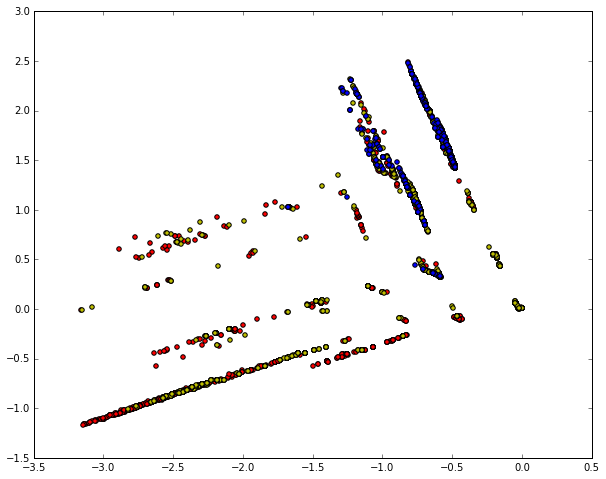

In [13]:
Z = np.dot(X, U[:, 0:2])
df = pd.DataFrame({'x1': Z[:,0], 'x2': Z[:,1], 'y': df_train.fault_severity})
df0 = df[df.y == 0]
df1 = df[df.y == 1]
df2 = df[df.y == 2]
rcParams['figure.figsize'] = 10, 8
plt.scatter(df0.x1, df0.x2, c='r')
plt.scatter(df1.x1, df1.x2, c='y')
plt.scatter(df2.x1, df2.x2, c='b')
plt.show()

Calculate how many dimensions are needed to ratain given variance

In [22]:
for k in range(1, len(s)):
    var = s[0:k].sum()/s.sum()
    if var > 0.90:
        print('%d vectors for %g variance' % (k, var))
        break
        
for k in range(k, len(s)):
    var = s[0:k].sum()/s.sum()
    if var > 0.99:
        print('%d vectors for %g variance' % (k, var))
        break        

for k in range(k, len(s)):
    var = s[0:k].sum()/s.sum()
    if var > 0.999:
        print('%d vectors for %g variance' % (k, var))
        break        

175 vectors for 0.900428 variance
296 vectors for 0.990155 variance
322 vectors for 0.999245 variance


## T-SNE Visualization

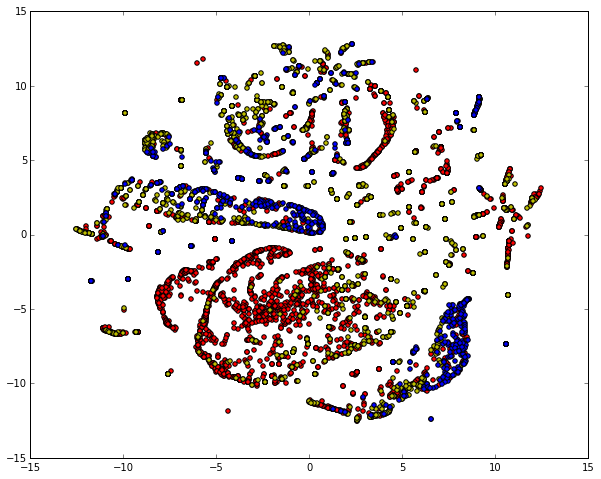

In [30]:
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Ts = model.fit_transform(X) 
df = pd.DataFrame({'x1': Ts[:,0], 'x2': Ts[:,1], 'y': df_train.fault_severity})
df0 = df[df.y == 0]
df1 = df[df.y == 1]
df2 = df[df.y == 2]
rcParams['figure.figsize'] = 10, 8
plt.scatter(df0.x1, df0.x2, c='r')
plt.scatter(df1.x1, df1.x2, c='y')
plt.scatter(df2.x1, df2.x2, c='b')
plt.show()

Visualization based on PCA

In [ ]:
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Z = np.dot(X, U[:, 0:296])
Ts = model.fit_transform(Z) 
df = pd.DataFrame({'x1': Ts[:,0], 'x2': Ts[:,1], 'y': df_train.fault_severity})
df0 = df[df.y == 0]
df1 = df[df.y == 1]
df2 = df[df.y == 2]
rcParams['figure.figsize'] = 10, 8
plt.scatter(df0.x1, df0.x2, c='r')
plt.scatter(df1.x1, df1.x2, c='y')
plt.scatter(df2.x1, df2.x2, c='b')
plt.show()